In [ ]:
!pip install -q kaggle

In [ ]:
!kaggle datasets download -d jxwleong/coral-reef-dataset

Dataset URL: https://www.kaggle.com/datasets/jxwleong/coral-reef-dataset
License(s): unknown
100% 18.3G/18.3G [04:10<00:00, 80.5MB/s]
100% 18.3G/18.3G [04:10<00:00, 78.5MB/s]


In [ ]:
!unzip coral-reef-dataset.zip

Archive:  coral-reef-dataset.zip
  inflating: combined_annotations_remapped.csv  
  inflating: images/images/.gitkeep  
  inflating: images/images/__init__.py  
  inflating: images/images/i0201a.png  
  inflating: images/images/i0201b.png  
  inflating: images/images/i0201c.png  
  inflating: images/images/i0201d.png  
  inflating: images/images/i0202a.png  
  inflating: images/images/i0202b.png  
  inflating: images/images/i0202c.png  
  inflating: images/images/i0202d.png  
  inflating: images/images/i0203a.png  
  inflating: images/images/i0203b.png  
  inflating: images/images/i0203c.png  
  inflating: images/images/i0203d.png  
  inflating: images/images/i0204a.png  
  inflating: images/images/i0204b.png  
  inflating: images/images/i0204c.png  
  inflating: images/images/i0204d.png  
  inflating: images/images/i0205a.png  
  inflating: images/images/i0205b.png  
  inflating: images/images/i0205c.png  
  inflating: images/images/i0205d.png  
  inflating: images/images/i0206a.png  

In [ ]:
import os

os.getcwd()

'/content'

In [ ]:
base_path = "/content/images/images/"

In [ ]:
import pandas as pd

indx = pd.read_csv("/content/combined_annotations_remapped.csv")

In [ ]:
indx.head(5)

,Name,Row,Column,Label,Unnamed: 4
0,i0201a.png,111,94,broken_coral_rubble,NaN
1,i0201a.png,173,243,broken_coral_rubble,NaN
2,i0201a.png,84,366,broken_coral_rubble,NaN
3,i0201a.png,54,802,broken_coral_rubble,NaN
4,i0201a.png,313,66,sand,NaN


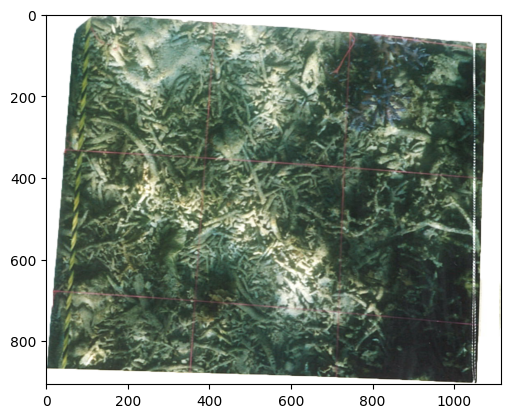

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(plt.imread("/content/images/images/i0201a.png"))
plt.show()

In [ ]:
len(set(indx.Label.values))

40

In [ ]:
indx["Label"].value_counts()

,count
Label,
crustose_coralline_algae,226017
turf,43769
sand,38880
porites,35236
macroalgae,23832
off,13605
pocillopora,11319
montipora,8755
pavona,5806


In [ ]:
indx = indx[indx['Label'].isin(["off","turf","sand","porites","macroalgae"])]

In [ ]:

indx.reset_index(drop=True, inplace=True)
indx.head(5)

,Name,Row,Column,Label,Unnamed: 4
0,i0201a.png,313,66,sand,NaN
1,i0201d.png,496,726,sand,NaN
2,i0202b.png,170,329,sand,NaN
3,i0202b.png,350,66,sand,NaN
4,i0202b.png,401,19,sand,NaN


In [ ]:
indx["Label"].value_counts()

,count
Label,
turf,43769
sand,38880
porites,35236
macroalgae,23832
off,13605


In [ ]:

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(indx, test_size= 0.2, random_state=42)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

class ImageDatasetFromCSV(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):

        self.img_dir = img_dir
        self.transform = transform

        valid_rows = []
        for idx, row in tqdm(csv_file.iterrows()):
            img_name = os.path.join(self.img_dir, row[0])
            try:
                image = Image.open(img_name)

                if image.mode != 'RGB':
                    image = image.convert('RGB')

                valid_rows.append(row)
            except Exception as e:
                print(f"Error opening image {img_name}: {e}")

        self.data_frame = pd.DataFrame(valid_rows, columns=csv_file.columns)

        self.OneHotEncoder = OneHotEncoder()
        self.targets = self.OneHotEncoder.fit_transform(self.data_frame["Label"].values.reshape(-1, 1))


    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.img_dir, self.data_frame.iloc[idx, 0])

        try:
            image = Image.open(img_name)

            if image.mode != 'RGB':
                image = image.convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
            return None, None

        label = self.targets[idx].toarray().squeeze(0)
        label = np.array(label).astype(int)
        label = torch.from_numpy(label)

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset_train = ImageDatasetFromCSV(csv_file=train_df, img_dir='/content/images/images/', transform=transform)
dataset_test = ImageDatasetFromCSV(csv_file=test_df, img_dir='/content/images/images/', transform=transform)


0it [00:00, ?it/s]<ipython-input-33-1554d344aa23>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_name = os.path.join(self.img_dir, row[0])
124257it [01:26, 1430.68it/s]
0it [00:00, ?it/s]<ipython-input-33-1554d344aa23>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_name = os.path.join(self.img_dir, row[0])
31065it [00:22, 1411.97it/s]


In [ ]:
from torch.utils.data import DataLoader

train_data_loader = DataLoader(dataset_train, batch_size=64, shuffle=True)
test_data_loader = DataLoader(dataset_test, batch_size=64, shuffle=True)

In [ ]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import pandas as pd
import numpy as np


model = models.efficientnet_b0(pretrained=True)

num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 5)

model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

scaler = GradScaler()

num_epochs = 10
for epoch in tqdm(range(num_epochs)):

    model.train()
    running_loss = 0.0
    for batch in tqdm(train_data_loader):
        images, labels = batch

        if images is None or labels is None:
            continue

        images = images.float().to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()

        with autocast():  # Mixed precision training
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {running_loss / len(train_data_loader):.4f}")

    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in test_data_loader:

            if images is None or labels is None:
                continue

            images = images.float().to(device)
            labels = labels.float().to(device)

            outputs = model(images)
            predicted = torch.argmax(outputs, dim=1)
            labels = torch.argmax(labels, dim=1)

            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    validation_accuracy = total_correct / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {validation_accuracy:.4f}")

<ipython-input-38-8da3567dd0b3>:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
  0%|          | 0/1942 [00:00<?, ?it/s]<ipython-input-38-8da3567dd0b3>:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training

100%|██████████| 1942/1942 [2:28:51<00:00,  4.60s/it]


Epoch [1/10], Training Loss: 0.8912


  0%|          | 0/10 [2:40:06<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for images, labels in tqdm(test_data_loader):
        if images is None or labels is None:
            continue

        images = images.float().to(device)
        labels = labels.float().to(device)

        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        labels = torch.argmax(labels, dim=1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

    validation_accuracy = total_correct / total_samples
    print(f"Validation Accuracy: {validation_accuracy:.4f}")

100%|██████████| 486/486 [35:42<00:00,  4.41s/it]

Validation Accuracy: 0.6797


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/research/ganesh_Sir/Coral_Model.pth')